#### TLO-32410 - Johdanto datatieteeseen, kevät 2020
# Harjoitustyö
#### Katri Tuunanen


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

LISTINGSFILE = 'http://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2020-03-19/data/listings.csv.gz'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating',
        'latitude',
        'longitude'
        ]

df = pd.read_csv(LISTINGSFILE, usecols=cols)
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.lower()
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace(u"ñ","n")
len(df.index)

23968

In [2]:
df.head(2)

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month
0,palermo,-34.58184,-58.42415,Entire home/apt,2,1.0,1.0,"$3,802.00",21,26,95.0,f,0.28
1,recoleta,-34.59761,-58.39468,Private room,1,1.0,1.0,"$1,521.00",30,20,95.0,f,0.16


In [3]:
PARKSFILE = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/espacios-verdes/espacio-verde-publico.csv'

cols = ['barrio',
        'area']

df2 = pd.read_csv(PARKSFILE, usecols=cols)
df2 = df2.dropna()  #Remove rows with NaN values
df2 = df2.replace('BALBANERA', 'BALVANERA') #Fix typos

df2.head(5)

,barrio,area
0,COLEGIALES,1658.266
1,COLEGIALES,3.984
2,COLEGIALES,4686.060
3,BELGRANO,3746.965
4,BELGRANO,558.986


In [4]:
import unicodedata #for normalizing the spanish letters

neigh_dict = {}    #key: neighbourhood, value: total green area

for i in range(len(df2)):
    neigh = str(df2.barrio.iloc[i])
    neigh = unicodedata.normalize('NFKD', neigh).encode('ascii', 'ignore')
    neigh = str(neigh)
    neigh = neigh[2:-1]  #format the string because it turned out weird
    neigh = neigh.lower()
    area = df2.area.iloc[i]
    
    if neigh in neigh_dict:
        neigh_dict[neigh] += area
        
    else:
        neigh_dict[neigh] = area
        
for i in neigh_dict:
    neigh_dict[i] = float("{0:.2f}".format(neigh_dict[i]))

print(neigh_dict)  

{'colegiales': 49648.76, 'belgrano': 1285919.89, 'palermo': 2220344.16, 'saavedra': 841083.84, 'parque avellaneda': 540598.94, 'villa ortuzar': 13611.58, 'villa del parque': 16665.38, 'flores': 212662.4, 'villa soldati': 2920416.78, 'caballito': 215695.44, 'villa lugano': 1194540.33, 'mataderos': 117313.25, 'liniers': 60001.55, 'villa riachuelo': 53934.44, 'villa urquiza': 42746.21, 'nueva pompeya': 86466.72, 'paternal': 81800.31, 'villa real': 1107849.5, 'parque patricios': 249475.83, 'parque chacabuco': 129775.94, 'san cristobal': 15730.44, 'villa gral. mitre': 14182.66, 'almagro': 8758.2, 'san telmo': 66324.25, 'retiro': 138432.37, 'recoleta': 336135.19, 'versalles': 33870.62, 'san nicolas': 64721.58, 'puerto madero': 2825733.68, 'monserrat': 72578.92, 'villa devoto': 79363.31, 'floresta': 19737.56, 'balvanera': 30173.79, 'chacarita': 93357.74, 'velez sarsfield': 28238.8, 'villa luro': 32149.23, 'constitucion': 74322.04, 'villa santa rita': 355.21, 'barracas': 185681.53, 'nunez': 41

In [5]:
#Next, add a new column, that tells the total green area in the neigbourhood, to the Airbnb data.

df['neigh_green_area'] = df['neighbourhood_cleansed'].map(neigh_dict)

df.head(10)

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,neigh_green_area
0,palermo,-34.58184,-58.42415,Entire home/apt,2,1.0,1.0,"$3,802.00",21,26,95.0,f,0.28,2220344.16
1,recoleta,-34.59761,-58.39468,Private room,1,1.0,1.0,"$1,521.00",30,20,95.0,f,0.16,336135.19
2,palermo,-34.59382,-58.42994,Private room,2,1.0,1.0,"$2,851.00",30,1,100.0,f,0.07,2220344.16
3,palermo,-34.59398,-58.42853,Private room,2,1.0,2.0,"$2,851.00",30,0,NaN,f,NaN,2220344.16
4,palermo,-34.59348,-58.42949,Private room,2,1.0,2.0,"$2,851.00",30,66,99.0,f,1.96,2220344.16
5,palermo,-34.59362,-58.42984,Private room,3,1.0,3.0,"$3,802.00",30,0,NaN,f,NaN,2220344.16
6,palermo,-34.59288,-58.43010,Private room,4,1.0,3.0,"$4,436.00",30,1,80.0,f,0.04,2220344.16
7,monserrat,-34.61564,-58.38823,Private room,2,1.0,1.0,"$4,436.00",30,0,NaN,f,NaN,72578.92
8,monserrat,-34.61780,-58.38640,Private room,2,1.0,2.0,"$3,802.00",30,0,NaN,f,NaN,72578.92
9,monserrat,-34.61715,-58.38832,Private room,3,1.0,1.0,"$4,436.00",30,0,NaN,f,NaN,72578.92


### Vaihe 3: datan jalostaminen

In [6]:
len(df.index)   #Tästä rivien määrästä lähdetään liikkeelle

23968

In [7]:
print(df.isnull().sum())

neighbourhood_cleansed       0
latitude                     0
longitude                    0
room_type                    0
accommodates                 0
bedrooms                    43
beds                       164
price                        0
availability_30              0
number_of_reviews            0
review_scores_rating      7025
instant_bookable             0
reviews_per_month         6636
neigh_green_area             0
dtype: int64


In [8]:
#Replace NaN with 0 in apartments with no reviews
df['reviews_per_month'].fillna(0, inplace=True)

#Remove apartments with bad values
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0) #Remove rows with NaN values
len(df.index)

13944

In [9]:
df = df[df.bedrooms == 1]
df = df[df.accommodates == 2]
len(df.index)

5531

### Lisätään piirre etäisyys lähimpään metroasemaan (subte)

In [10]:
SUBTEFILE = 'http://cdn.buenosaires.gob.ar/datosabiertos/datasets/subte-estaciones/estaciones-de-subte.csv'
cols = ['lat',
        'long']
df_subte = pd.read_csv(SUBTEFILE, usecols=cols)
df_subte.head(2)

,long,lat
0,-58.398928,-34.635750
1,-58.400970,-34.629376


In [11]:
distances = []

# loop through all airbnb apartments
for i in range(len(df)):
    shortest = 100    #a big value
    latitude = df.latitude.iloc[i]
    longitude = df.longitude.iloc[i]
    
    # count distance to all subte stations, find shortest
    for j in range(len(df_subte)):
        distance = np.sqrt(np.square(latitude - df_subte.lat.iloc[j]) \
                          + np.square(longitude - df_subte.long.iloc[j]))

        if (distance < shortest):
            shortest = distance
            
    distances.append(shortest)
    
df['closest_subway'] = distances
df.head(5)

,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,neigh_green_area,closest_subway
0,palermo,-34.58184,-58.42415,Entire home/apt,2,1.0,1.0,"$3,802.00",21,26,95.0,f,0.28,2220344.16,0.002985
2,palermo,-34.59382,-58.42994,Private room,2,1.0,1.0,"$2,851.00",30,1,100.0,f,0.07,2220344.16,0.008448
4,palermo,-34.59348,-58.42949,Private room,2,1.0,2.0,"$2,851.00",30,66,99.0,f,1.96,2220344.16,0.008864
31,chacarita,-34.58681,-58.44476,Entire home/apt,2,1.0,1.0,"$3,739.00",30,32,94.0,t,0.29,93357.74,0.005657
39,palermo,-34.57628,-58.43456,Entire home/apt,2,1.0,1.0,"$3,612.00",30,22,95.0,f,0.29,2220344.16,0.001191


In [12]:
print(df.isnull().sum())

neighbourhood_cleansed    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bedrooms                  0
beds                      0
price                     0
availability_30           0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
reviews_per_month         0
neigh_green_area          0
closest_subway            0
dtype: int64


In [13]:
# format price to a float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

# cleaning unrealistic prices
df = df[df.price < 25000.0]

# drop columns
df = df.drop(['latitude', 'longitude', 'accommodates', 'bedrooms'], axis=1)

len(df.index)

5509

In [14]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)

# convert boolean column to a single boolean value
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with new encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    ib_dummies.astype(int)), axis=1)
allcols = alldata.columns

In [15]:
df.head(2)

,neighbourhood_cleansed,room_type,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,neigh_green_area,closest_subway
0,palermo,Entire home/apt,1.0,3802.0,21,26,95.0,f,0.28,2220344.16,0.002985
2,palermo,Private room,1.0,2851.0,30,1,100.0,f,0.07,2220344.16,0.008448


### Vaihe 4: Datan kuvaileminen

In [16]:
nb_counts = Counter(df.neighbourhood_cleansed)
nb_counts

Counter({'palermo': 1763,
         'chacarita': 98,
         'recoleta': 855,
         'villa crespo': 201,
         'nunez': 116,
         'san nicolas': 285,
         'monserrat': 237,
         'retiro': 273,
         'san cristobal': 30,
         'san telmo': 171,
         'balvanera': 265,
         'puerto madero': 65,
         'belgrano': 225,
         'almagro': 234,
         'parque patricios': 20,
         'boca': 29,
         'constitucion': 90,
         'saavedra': 33,
         'caballito': 113,
         'colegiales': 107,
         'coghlan': 19,
         'villa ortuzar': 25,
         'parque chacabuco': 14,
         'barracas': 34,
         'flores': 13,
         'boedo': 27,
         'floresta': 8,
         'villa urquiza': 57,
         'parque chas': 9,
         'agronomia': 8,
         'parque avellaneda': 4,
         'villa del parque': 11,
         'paternal': 10,
         'villa devoto': 16,
         'villa gral. mitre': 12,
         'villa pueyrredon': 9,
         'vi

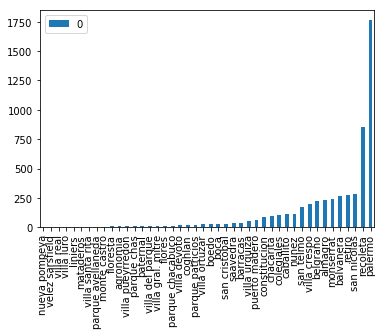

In [17]:
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

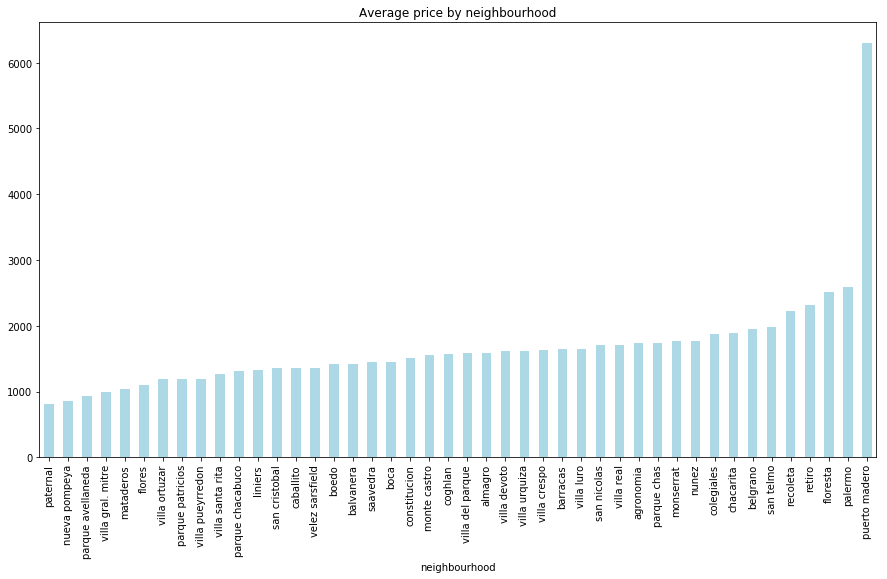

In [18]:
# find out average prices by neighbourhood

nbh_prices = df[['neighbourhood_cleansed', 'price']]
nbh_prices.columns = ['neighbourhood', 'price']

prices = nbh_prices.groupby('neighbourhood')
nbh_prices = prices['price'].agg(np.mean)
nbh_prices = nbh_prices.reset_index()
nbh_prices['number_of_listings'] = nb_counts.values()

p = nbh_prices.sort_values(by = 'price')
p.plot(x = "neighbourhood", y = "price", kind = 'bar', \
      color = 'LightBlue', figsize = (15, 8), \
      title = 'Average price by neighbourhood', legend = 0)

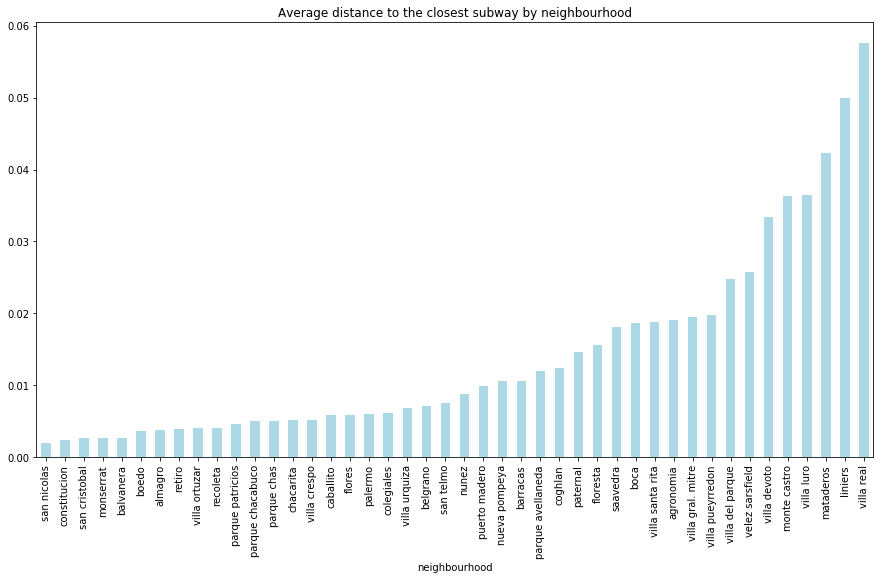

In [19]:
# count average distance to closest subway station by neighbourhood

nbh_prices = df[['neighbourhood_cleansed', 'closest_subway']]
nbh_prices.columns = ['neighbourhood', 'closest_subway']

prices = nbh_prices.groupby('neighbourhood')
nbh_prices = prices['closest_subway'].agg(np.mean)
nbh_prices = nbh_prices.reset_index()
nbh_prices['number_of_listings'] = nb_counts.values()

p = nbh_prices.sort_values(by = 'closest_subway')
p.plot(x = "neighbourhood", y = "closest_subway", kind = 'bar', \
      color = 'LightBlue', figsize = (15, 8), \
      title = 'Average distance to the closest subway by neighbourhood', legend = 0)

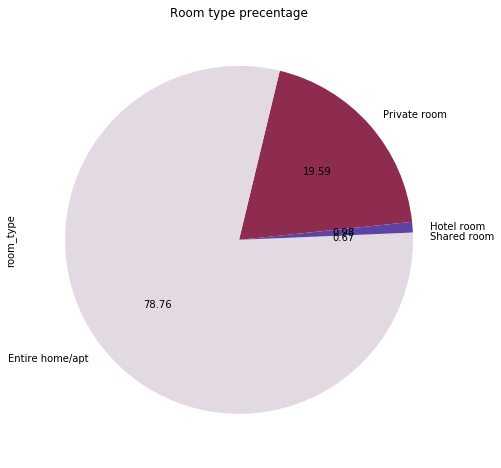

In [20]:
# Room type chart
r = Counter(df.room_type)
df_r = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
df_r.columns = ['room_type']
df_r.plot.pie(y = 'room_type', colormap = 'twilight',
              figsize = (8, 8), fontsize = 10, autopct = '%.2f',
              legend = False, title = 'Room type precentage')

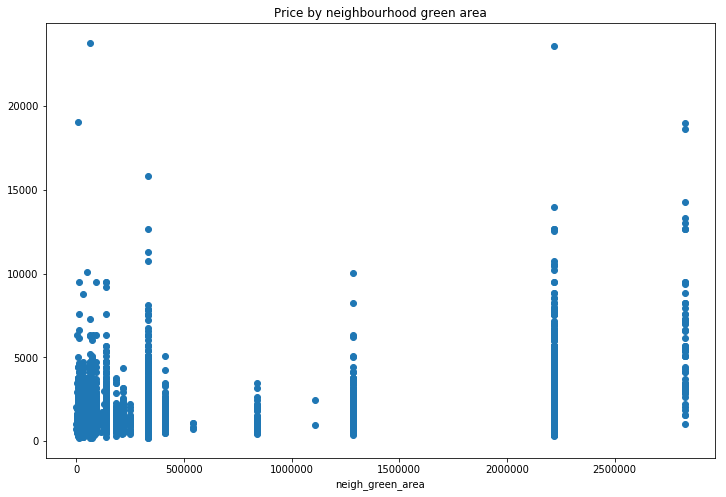

In [21]:
price_green = df[['price', 'neigh_green_area']]. sort_values(by = 'price')
price_green.plot(x = 'neigh_green_area', y = 'price', style = 'o',
                figsize = (12, 8), legend = False, 
                title = 'Price by neighbourhood green area')

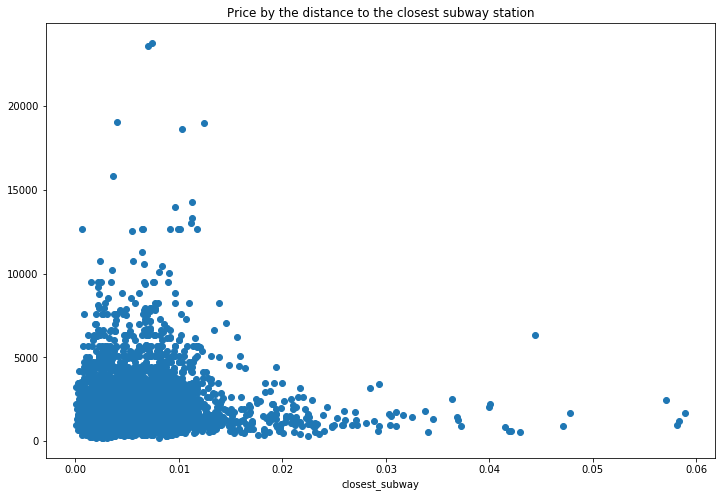

In [22]:
price_sw = df[['price', 'closest_subway']]. sort_values(by = 'price')
price_sw.plot(x = 'closest_subway', y = 'price', style = 'o',
                figsize = (12, 8), legend = False, 
                title = 'Price by the distance to the closest subway station')

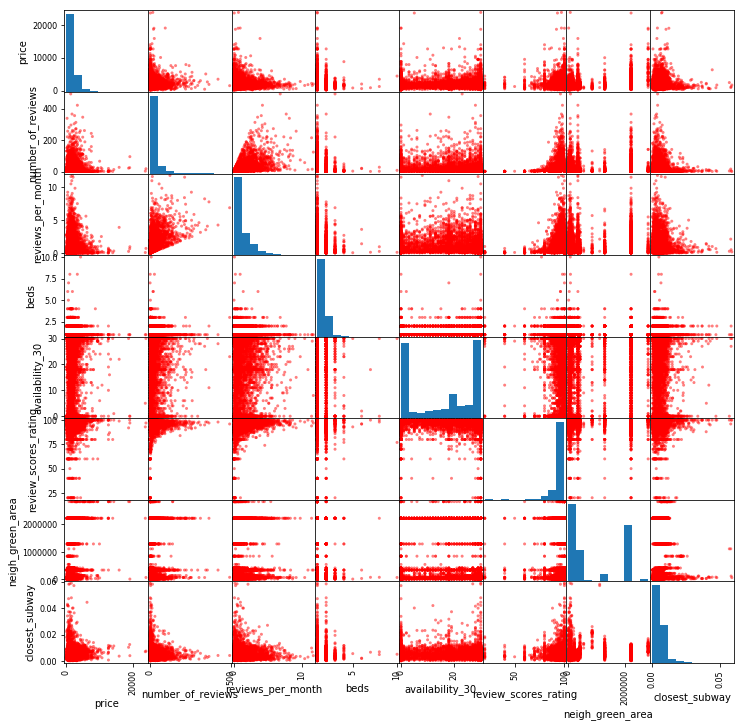

In [23]:
scattercols = ['price', 'number_of_reviews', 'reviews_per_month', \
               'beds', 'availability_30', 'review_scores_rating', \
               'neigh_green_area', 'closest_subway']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

### Vaihe 5: Koneoppiminen
#### i) Lineaarinen regressio

In [24]:
df.corr()

,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,neigh_green_area,closest_subway
beds,1.000000,-0.086522,0.040282,-0.052906,-0.047314,-0.074818,-0.064914,-0.034051
price,-0.086522,1.000000,0.133298,0.027189,0.020550,-0.074334,0.290658,0.025701
availability_30,0.040282,0.133298,1.000000,0.049538,-0.071769,0.049445,0.011141,0.004644
number_of_reviews,-0.052906,0.027189,0.049538,1.000000,0.048362,0.546290,0.051900,-0.055938
review_scores_rating,-0.047314,0.020550,-0.071769,0.048362,1.000000,0.117671,0.029151,0.036938
reviews_per_month,-0.074818,-0.074334,0.049445,0.546290,0.117671,1.000000,0.048436,-0.056934
neigh_green_area,-0.064914,0.290658,0.011141,0.051900,0.029151,0.048436,1.000000,0.123507
closest_subway,-0.034051,0.025701,0.004644,-0.055938,0.036938,-0.056934,0.123507,1.000000


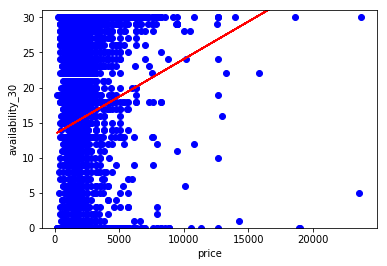

In [25]:
# price and availability
lr = linear_model.LinearRegression()
x = df['price'].values[:, np.newaxis]
y = df['availability_30']

classifier = lr.fit(x, y)

plt.scatter(x, y, color = 'b')
plt.plot(x, classifier.predict(x), color = 'r')
plt.xlabel('price')
plt.ylabel('availability_30')
plt.ylim([0, 31])
plt.show()

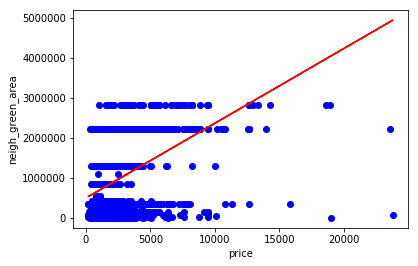

In [26]:
lr = linear_model.LinearRegression()
x = df['price'].values[:, np.newaxis]
y = df['neigh_green_area']

classifier = lr.fit(x, y)

plt.scatter(x, y, color = 'b')
plt.plot(x, classifier.predict(x), color = 'r')
plt.xlabel('price')
plt.ylabel('neigh_green_area')
plt.show()

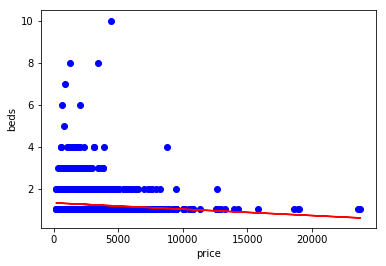

In [27]:
lr = linear_model.LinearRegression()
x = df['price'].values[:, np.newaxis]
y = df['beds']

classifier = lr.fit(x, y)

plt.scatter(x, y, color = 'b')
plt.plot(x, classifier.predict(x), color = 'r')
plt.xlabel('price')
plt.ylabel('beds')
plt.show()

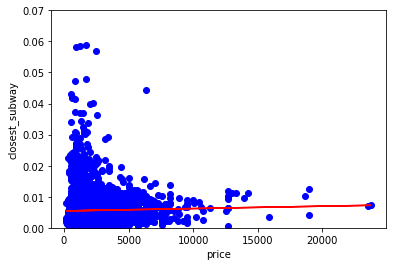

In [28]:

lr = linear_model.LinearRegression()
x = df['price'].values[:, np.newaxis]
y = df['closest_subway']

classifier = lr.fit(x, y)

plt.scatter(x, y, color = 'b')
plt.plot(x, classifier.predict(x), color = 'r')
plt.xlabel('price')
plt.ylabel('closest_subway')
plt.ylim([0, 0.07])
plt.show()

#### ii) Monimuuttujaregressio

Text(0.5, 0, 'Relative importance')

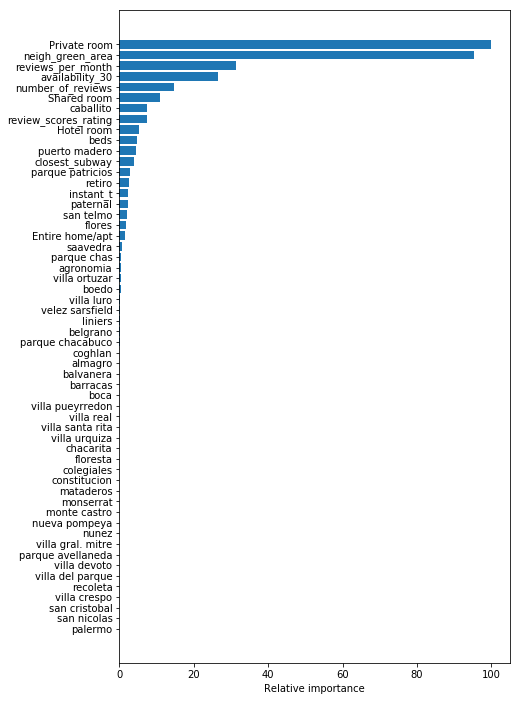

In [29]:
X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

n_est = 5000

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]

plt.figure(figsize=(7,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative importance')